In [4]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import sys


sys.path.insert(1, '../g3m_utils/')
from state_evolution.data_models.custom import Custom,CustomSpectra
from state_evolution.experiments.learning_curve import CustomExperiment
import pandas as pd
from scipy.special import erf
from scipy.optimize import minimize_scalar
from sklearn.linear_model import Ridge, RidgeCV

In [5]:
d=500

k1=700
k2=k1

In [6]:
Sigma=np.ones(d) #covariance matrix of data

In [7]:
activ="tanh2x"

f1=lambda x: np.tanh(2*x)
f2=lambda x: f1(x)#erf(x)

r_1=np.mean(Sigma)

k1_1=quad(lambda x: np.exp(-.5*x**2/r_1)*x*f1(x)/np.sqrt(2*np.pi*r_1),-np.inf,np.inf)[0]/r_1
var_1=quad(lambda x: np.exp(-.5*x**2/r_1)*f1(x)**2/np.sqrt(2*np.pi*r_1),-np.inf,np.inf)[0]
ks_1=np.sqrt(var_1-r_1*k1_1**2)

r_2=var_1
k1_2=quad(lambda x: np.exp(-.5*x**2/r_2)*x*f2(x)/np.sqrt(2*np.pi*r_2),-np.inf,np.inf)[0]/r_2
var_2=quad(lambda x: np.exp(-.5*x**2/r_2)*f2(x)**2/np.sqrt(2*np.pi*r_2),-np.inf,np.inf)[0]
ks_2=np.sqrt(var_2-r_2*k1_2**2)

print("var1={} var2={}".format(var_1,var_2))

var1=0.6352612342569396 var2=0.5616006371936293


In [8]:
theta=np.random.randn(k2)/np.sqrt(k2)
W1=np.random.randn(k1,d)/np.sqrt(d)
W2=np.random.randn(k2,k1)/np.sqrt(k1)

In [9]:


Omega=np.eye(d)  

In [10]:
def error_lamb(log_lamb,alpha,data_model):
    experiment = CustomExperiment(task = 'l2_classification', 
                                  regularisation = 10**(-log_lamb), 
                                  data_model = data_model, 
                                  tolerance = 1e-6, 
                                  damping = 0.5, 
                                  verbose = False, 
                                  max_steps = 10000)
    
    experiment.learning_curve(alphas =[alpha])
    
    return experiment.get_curve()["test_error"].values[0]

In [11]:
def replica(alphas,lamb=0.1,verbose=False,opt_reg=False):   
    
    data_model=data_model=CustomSpectra(  rho=k1_1**2*k1_2**2+k1_2**2*ks_1**2+ks_2**2,
                                  spec_Omega = np.array([1]), 
                               spec_UPhiPhitUT=np.array([k2/d*k1_1**2*k1_2**2]), 
                               gamma=k2/d)
    
    if opt_reg:
        minimization=minimize_scalar(error_lamb, (-1,4),args=(alphas[0], data_model),tol=1e-5)
        log_lamb=minimization.x
        lamb=10**(-log_lamb)
    
    experiment = CustomExperiment(task = 'l2_classification', 
                                  regularisation = lamb, 
                                  data_model = data_model, 
                                  tolerance = 1e-6, 
                                  damping = 0.2, 
                                  verbose = verbose, 
                                  max_steps = 10000)
    
    
    
    experiment.learning_curve(alphas =[alphas[0]])
    replicas=experiment.get_curve()


    for i in range(1,len(alphas)):
        print("sample",alphas[i])
        print(replicas["test_error"])
                             
               
        if opt_reg:
            minimization=minimize_scalar(error_lamb, (-1,4),args=(alphas[i], data_model),tol=1e-5)
            log_lamb=minimization.x
            lamb=10**(-log_lamb)
        
        experiment = CustomExperiment(task = 'l2_classification', 
                                  regularisation = lamb, 
                                  data_model = data_model, 
                                  tolerance = 1e-6, 
                                  damping = 0.2, 
                                  verbose = verbose, 
                                  max_steps = 10000)
        experiment.learning_curve(alphas =[alphas[i]])
        replicas=pd.concat([replicas,experiment.get_curve()])
        

    
    return replicas

In [14]:
alphas=np.linspace(.1,7,20)

In [15]:
repl=replica(alphas,opt_reg=False,lamb=0.1)

sample 0.4631578947368421
0    0.442536
Name: test_error, dtype: float64
sample 0.8263157894736842
0    0.442536
0    0.386484
Name: test_error, dtype: float64
sample 1.1894736842105265
0    0.442536
0    0.386484
0    0.361930
Name: test_error, dtype: float64
sample 1.5526315789473686
0    0.442536
0    0.386484
0    0.361930
0    0.340603
Name: test_error, dtype: float64
sample 1.9157894736842107
0    0.442536
0    0.386484
0    0.361930
0    0.340603
0    0.317681
Name: test_error, dtype: float64
sample 2.278947368421053
0    0.442536
0    0.386484
0    0.361930
0    0.340603
0    0.317681
0    0.297855
Name: test_error, dtype: float64
sample 2.642105263157895
0    0.442536
0    0.386484
0    0.361930
0    0.340603
0    0.317681
0    0.297855
0    0.282122
Name: test_error, dtype: float64
sample 3.005263157894737
0    0.442536
0    0.386484
0    0.361930
0    0.340603
0    0.317681
0    0.297855
0    0.282122
0    0.269730
Name: test_error, dtype: float64
sample 3.368421052631579
0 

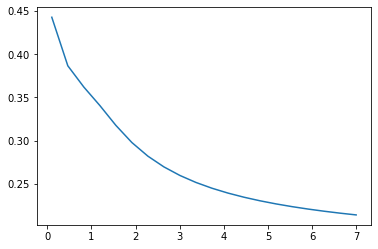

In [17]:
plt.plot(repl["sample_complexity"],repl["test_error"])
